In [1]:
# 基本库
import os
import pandas as pd
import numpy as np
import time

#工具库
from utils import *

#深度学习
np.random.seed(1337)  # for reproducibility

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from sklearn.metrics import  f1_score,precision_score,recall_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import lightgbm as lgb

from matplotlib import pyplot as plt
%matplotlib inline

两种筛选方式

一、len

二、变异位置

v2.3纯随机

In [2]:
print('Loading data...')
df1 = pd.read_csv('./Data/All_species_train_v2.3.csv')
df2 = pd.read_csv('./Data/Blind_All_species_v2.3.csv')
df1 =  df1[df1['len']<=1500].reset_index(drop=True)
df2 =  df2[df2['len']<=1500].reset_index(drop=True)

Loading data...


v2.1按蛋白

In [2]:
print('Loading data...')
df1 = pd.read_csv('./Data/All_species_train_v2.1.csv')
df2 = pd.read_csv('./Data/Blind_All_species_v2.1.csv')
df1 =  df1[df1['mut_residue']<=1000].reset_index(drop=True)
df2 =  df2[df2['mut_residue']<=1000].reset_index(drop=True)

Loading data...


In [3]:
df1,df2 = calculate_LR(df1,df2)
df1,df2 = calculate_PA(df1,df2)

### Encoding

| AA | Code   | 
| ---|:-------:| 
| A  | 1     |
| C  | 2     |
| D  | 3     |
| E  | 4     |
| F  | 5     |
| G  | 6     |
| H  | 7     |
| I  | 8     |
| K  | 9     |
| L  | 10     |
| M  | 11     |
| N  | 12     |
| P  | 13     |
| Q  | 14     |
| R  | 15     |
| S  | 16     |
| T  | 17     |
| V  | 18     |
| W  | 19     |
| Y  | 20     |
| B,J,O,U,X,Z  | 0     |

选取的子序列长度[Length]，-1为全部，如果是全部就需要开头多一个pos

每一个开头都要有一个转换完的属性

eg.

Length = 8

MSFM(A)VPT[原序列]-->XMSFMVPT[填充7->8]-->AXMSFMVPT

思路二：

原先一条变异数据转换为两条序列信息

思路三：

同一条变异，序列深度学习提取20个属性，加生物特征, 机器学习

In [4]:
#Encoding
def trans(str1):
    a = []
    dic = {'A':1,'B':0,'U':0,'J':0,'Z':0,'O':0,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20,'X':0}
    for i in range(len(str1)):
        a.append(dic.get(str1[i]))
    return a

def Encoding(df1, df2):
    #全序列
    df1['encode'] = df1['seq'].apply(lambda x: trans(x))
    df2['encode'] = df2['seq'].apply(lambda x: trans(x))
    return df1,df2

df1, df2 = Encoding(df1, df2)

df1 = df1.drop(labels=['nutation', 'name', 'seq'],axis=1)
df2 = df2.drop(labels=['nutation', 'name', 'seq'],axis=1)

In [5]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    #函数开始时创建盛放loss与acc的容器
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    
    #按照batch来进行追加数据
    def on_batch_end(self, batch, logs={}):
        #每一个batch完成后向容器里面追加loss，acc
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))

    def on_epoch_end(self, batch, logs={}):
        # 每一个epoch完成后向容器里面追加loss，acc
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
            plt.grid(True)
            plt.xlabel(loss_type)
            plt.ylabel('acc-loss')
            plt.legend(loc="upper right")
            plt.show()

### 参数

In [6]:
seed=113

# Embedding
max_features = 21
maxlen = 1500
embedding_size = 128

# Convolution
#filter_length = 3
nb_filter = 64
pool_length = 2

# LSTM
# lstm_output_size = 20
lstm_output_size = 70

# Training
batch_size = 128
nb_epoch = 30

### Input

分开生物特征

df1 = df1.drop(labels=['nutation', 'name', 'seq', 'seq2'],axis=1)

df1.iloc[:,4:-1]

深度学习特征

df1.iloc[:,-1]

#注意归一化

In [7]:
## Label
y_train = df1.is_del
y_train = np.array(y_train).reshape(-1,1)
y_test = df2.is_del
y_test = np.array(y_test).reshape(-1,1)
#reshape(-1,1)
#行数-1，列数1
#指定为-1的时候，其行或列会随机分配一个数据（自动计算）


# 神经网络（变异前序列）
X_train_1 = np.array(df1.iloc[:,-1])
X_test_1 = np.array(df2.iloc[:,-1])


# （生物特征）(归一化)
# X_test_2 = minmaxscaler(df2.iloc[:,4:-1])
# X_train_2 = minmaxscaler(df1.iloc[:,4:-1])
# X_test_2 = feature_normalize(df2.iloc[:,4:-1])
# X_train_2 = feature_normalize(df1.iloc[:,4:-1])
X_train_2 = df1.iloc[:,4:-1]
X_test_2 = df2.iloc[:,4:-1]



# np.random.seed(seed)
# np.random.shuffle(y_test)
# np.random.seed(seed)
# np.random.shuffle(y_train)

# np.random.seed(seed)
# np.random.shuffle(X_test_1)
# np.random.seed(seed)
# np.random.shuffle(X_train_1)

# np.random.seed(seed)
# np.random.shuffle(X_test_2)
# np.random.seed(seed)
# np.random.shuffle(X_train_2)

In [8]:
print(len(df1), 'train sequences')
print(len(df2), 'test sequences')

print('Pad sequences (samples x time)')
X_test_1 = sequence.pad_sequences(X_test_1, maxlen=maxlen)
X_train_1 = sequence.pad_sequences(X_train_1, maxlen=maxlen)
print('X_test_1 shape:', X_test_1.shape)
print('X_train_1 shape:', X_train_1.shape)

print('X_test_2 shape:', X_test_2.shape)
print('X_train_2 shape:', X_train_2.shape)


print('Build model...')

31661 train sequences
3518 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3518, 1500)
X_train_1 shape: (31661, 1500)
X_test_2 shape: (3518, 1085)
X_train_2 shape: (31661, 1085)
Build model...


筛选特征的个数选择

In [8]:
no_reject(X_train = X_train_2, y_train = y_train.reshape(1,-1)[0], X_test = X_test_2, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'compare/LGBM_all.csv')
# no_reject(X_train = X_train_2, y_train = y_train.reshape(1,-1)[0], X_test = X_test_2, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 10, filename = 'compare/LGBM_all_10.csv')
no_reject(X_train = X_train_2, y_train = y_train.reshape(1,-1)[0], X_test = X_test_2, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 20, filename = 'compare/LGBM_all_20.csv')
# no_reject(X_train = X_train_2, y_train = y_train.reshape(1,-1)[0], X_test = X_test_2, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 50, filename = 'compare/LGBM_all_50.csv')
# no_reject(X_train = X_train_2, y_train = y_train.reshape(1,-1)[0], X_test = X_test_2, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 100, filename = 'compare/LGBM_all_100.csv')

### Net

网络结构的选择

Net1

In [9]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
# model.add(Dropout(0.5))
# model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
# model.add(MaxPooling1D(pool_size=pool_length))
# model.add(BatchNormalization())
# model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
# model.add(MaxPooling1D(pool_size=pool_length))
# model.add(BatchNormalization())
model.add(LSTM(lstm_output_size, dropout=0.2))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = LossHistory()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1500, 128)         2688      
_________________________________________________________________
lstm (LSTM)                  (None, 70)                55720     
_________________________________________________________________
dense (Dense)                (None, 1)                 71        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 58,479
Trainable params: 58,479
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
248/248 [==============================] - 25s 100ms/step - loss: 0.6594 - accuracy: 0.6022 - val_loss: 0.6573 - val_accuracy: 0.6100
Epoch 2/30
248/248 [==============================] - 25s 102ms/step - loss: 0.6461 - accuracy: 0.6154 - val_loss: 0.6358 - val_accuracy: 0.6256
Epoch 3/30
248/248 [==============================] - 26s 104ms/step - loss: 0.6200 - accuracy: 0.6459 - val_loss: 0.6476 - val_accuracy: 0.6353
Epoch 4/30
248/248 [==============================] - 26s 103ms/step - loss: 0.6193 - accuracy: 0.6458 - val_loss: 0.5995 - val_accuracy: 0.6728
Epoch 5/30
248/248 [==============================] - 26s 104ms/step - loss: 0.5848 - accuracy: 0.6768 - val_loss: 0.6256 - val_accuracy: 0.6413
Epoch 6/30
248/248 [==============================] - 26s 103ms/step - loss: 0.6005 - accuracy: 0.6683 - val_loss: 0.5960 - val_accuracy: 0.6836
Epoch 7/30
248/248 [==============================] - 26s 103ms/step - loss: 0.5617 - accuracy: 0.7017 - val_loss: 0.5530 - val_ac

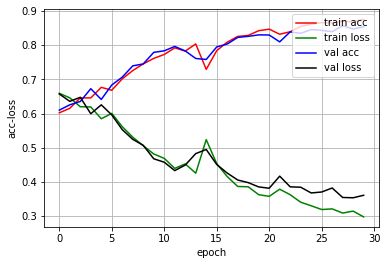

In [10]:
model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])

#模型评估
score = model.evaluate(X_test_1, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#绘制acc-loss曲线
history.loss_plot('epoch')

In [11]:
## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-3).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine_1.csv')

Net2

In [13]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
# model.add(Dropout(0.5))
# model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
# model.add(MaxPooling1D(pool_size=pool_length))
# model.add(BatchNormalization())
# model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
# model.add(MaxPooling1D(pool_size=pool_length))
# model.add(BatchNormalization())
model.add(LSTM(lstm_output_size, dropout=0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = LossHistory()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                55720     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 568       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 58,985
Trainable params: 58,985
Non-trainable params: 0
__________________________________________________

Epoch 1/30
248/248 [==============================] - 26s 104ms/step - loss: 0.6695 - accuracy: 0.5868 - val_loss: 0.6620 - val_accuracy: 0.6063
Epoch 2/30
248/248 [==============================] - 26s 103ms/step - loss: 0.6361 - accuracy: 0.6306 - val_loss: 0.6580 - val_accuracy: 0.6200
Epoch 3/30
248/248 [==============================] - 26s 103ms/step - loss: 0.6150 - accuracy: 0.6507 - val_loss: 0.5929 - val_accuracy: 0.6811
Epoch 4/30
248/248 [==============================] - 25s 103ms/step - loss: 0.5893 - accuracy: 0.6748 - val_loss: 0.5603 - val_accuracy: 0.7024
Epoch 5/30
248/248 [==============================] - 25s 103ms/step - loss: 0.5708 - accuracy: 0.6893 - val_loss: 0.5729 - val_accuracy: 0.6771
Epoch 6/30
248/248 [==============================] - 25s 103ms/step - loss: 0.5463 - accuracy: 0.7092 - val_loss: 0.5308 - val_accuracy: 0.7200
Epoch 7/30
248/248 [==============================] - 26s 103ms/step - loss: 0.5324 - accuracy: 0.7216 - val_loss: 0.5226 - val_ac

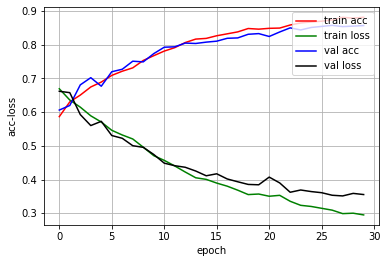

In [14]:
model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])

#模型评估
score = model.evaluate(X_test_1, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#绘制acc-loss曲线
history.loss_plot('epoch')

In [15]:
## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine_2.csv')

Net3

In [22]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.5))
model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_length))
# model.add(BatchNormalization())
model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_length))
# model.add(BatchNormalization())
model.add(LSTM(lstm_output_size, dropout=0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = LossHistory()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1500, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 745, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 741, 64)           20544     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 370, 64)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 70)               

Epoch 1/30
248/248 [==============================] - 17s 67ms/step - loss: 0.6516 - accuracy: 0.6031 - val_loss: 0.5565 - val_accuracy: 0.6970
Epoch 2/30
248/248 [==============================] - 16s 66ms/step - loss: 0.5228 - accuracy: 0.7297 - val_loss: 0.4382 - val_accuracy: 0.7911
Epoch 3/30
248/248 [==============================] - 16s 66ms/step - loss: 0.4509 - accuracy: 0.7863 - val_loss: 0.3958 - val_accuracy: 0.8198
Epoch 4/30
248/248 [==============================] - 16s 66ms/step - loss: 0.4121 - accuracy: 0.8174 - val_loss: 0.3844 - val_accuracy: 0.8380
Epoch 5/30
248/248 [==============================] - 16s 66ms/step - loss: 0.3899 - accuracy: 0.8343 - val_loss: 0.3813 - val_accuracy: 0.8422
Epoch 6/30
248/248 [==============================] - 16s 65ms/step - loss: 0.3660 - accuracy: 0.8489 - val_loss: 0.3385 - val_accuracy: 0.8582
Epoch 7/30
248/248 [==============================] - 16s 65ms/step - loss: 0.3497 - accuracy: 0.8572 - val_loss: 0.3515 - val_accuracy:

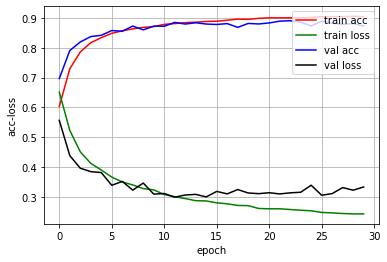

In [23]:
model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])

#模型评估
score = model.evaluate(X_test_1, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#绘制acc-loss曲线
history.loss_plot('epoch')

In [21]:
## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine_3.csv')

Net4

论文采用的网络

In [9]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.5))
model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_length))
model.add(BatchNormalization())
model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_length))
model.add(BatchNormalization())
model.add(LSTM(lstm_output_size, dropout=0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = LossHistory()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1500, 128)         2688      
_________________________________________________________________
dropout (Dropout)            (None, 1500, 128)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 745, 64)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 745, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 741, 64)           20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 370, 64)           0

Epoch 1/30
248/248 [==============================] - 17s 70ms/step - loss: 0.6111 - accuracy: 0.6389 - val_loss: 0.6534 - val_accuracy: 0.7291
Epoch 2/30
248/248 [==============================] - 17s 68ms/step - loss: 0.4942 - accuracy: 0.7498 - val_loss: 0.5304 - val_accuracy: 0.7342
Epoch 3/30
248/248 [==============================] - 17s 68ms/step - loss: 0.4375 - accuracy: 0.7930 - val_loss: 0.4952 - val_accuracy: 0.7379
Epoch 4/30
248/248 [==============================] - 17s 67ms/step - loss: 0.4040 - accuracy: 0.8195 - val_loss: 0.3564 - val_accuracy: 0.8479
Epoch 5/30
248/248 [==============================] - 17s 67ms/step - loss: 0.3724 - accuracy: 0.8397 - val_loss: 0.3418 - val_accuracy: 0.8579
Epoch 6/30
248/248 [==============================] - 17s 67ms/step - loss: 0.3548 - accuracy: 0.8502 - val_loss: 0.3259 - val_accuracy: 0.8624
Epoch 7/30
248/248 [==============================] - 17s 67ms/step - loss: 0.3354 - accuracy: 0.8630 - val_loss: 0.3204 - val_accuracy:

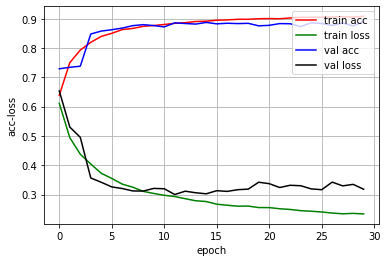

In [17]:
model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])

#模型评估
score = model.evaluate(X_test_1, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#绘制acc-loss曲线
history.loss_plot('epoch')

AUC1 :  0.9724161243158618
AUC2 :  0.9716744083739827
AUC3 :  0.9583649255372829
AUC4 :  0.9592557609947339


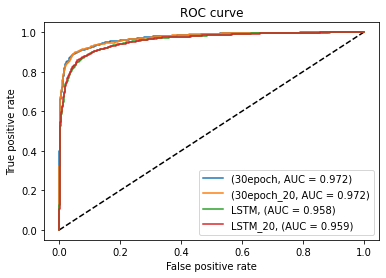

In [11]:
#画ROC
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')

## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_3, y_train.reshape(1,-1)[0])
y_pred1 = model_lgb.predict_proba(X_test_3)
y_pred1 = [y[1] for y in y_pred1]  # 取出y中的一列
fpr1, tpr1, thresholds_keras1 = roc_curve(y_test.reshape(1,-1)[0], y_pred1)   
auc1 = auc(fpr1, tpr1)
print("AUC1 : ", auc1)
plt.plot(fpr1, tpr1, label='(30epoch, AUC = {:.3f})'.format(auc1))

## 共70+20个

X_train_3 = pd.concat([pd.DataFrame(train_output),pd.DataFrame(rfe.transform(X_train_2.reset_index(drop=True)), columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't'])],axis=1)
X_train_3

## 共70+20个

X_test_3 = pd.concat([pd.DataFrame(test_output),pd.DataFrame(rfe.transform(X_test_2.reset_index(drop=True)), columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't'])],axis=1)
X_test_3

model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_3, y_train.reshape(1,-1)[0])
y_pred2 = model_lgb.predict_proba(X_test_3)
y_pred2 = [y[1] for y in y_pred2]  # 取出y中的一列
fpr2, tpr2, thresholds_keras2 = roc_curve(y_test.reshape(1,-1)[0], y_pred2)   
auc2 = auc(fpr2, tpr2)
print("AUC2 : ", auc2)
plt.plot(fpr2, tpr2, label='(30epoch_20, AUC = {:.3f})'.format(auc2))

model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_2, y_train.reshape(1,-1)[0])
y_pred3 = model_lgb.predict_proba(X_test_2)
y_pred3 = [y[1] for y in y_pred3]  # 取出y中的一列
fpr3, tpr3, thresholds_keras3 = roc_curve(y_test.reshape(1,-1)[0], y_pred3)   
auc3 = auc(fpr3, tpr3)
print("AUC3 : ", auc3)
plt.plot(fpr3, tpr3, label='LSTM, (AUC = {:.3f})'.format(auc3))

rfe = joblib.load('Feature_selected_1/lightgbm_feature_select_20.rfe')
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(pd.DataFrame(rfe.transform(X_train_2)), y_train.reshape(1,-1)[0])
y_pred4 = model_lgb.predict_proba(pd.DataFrame(rfe.transform(X_test_2)))
y_pred4 = [y[1] for y in y_pred4]  # 取出y中的一列
fpr4, tpr4, thresholds_keras4 = roc_curve(y_test.reshape(1,-1)[0], y_pred4)   
auc4 = auc(fpr4, tpr4)
print("AUC4 : ", auc4)
plt.plot(fpr4, tpr4, label='LSTM_20, (AUC = {:.3f})'.format(auc4))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show() 

# no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine_4.csv')



In [15]:
## LSTM层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## LSTM层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'blindtest.csv')


## LSTM层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+20个

X_train_3 = pd.concat([pd.DataFrame(train_output),pd.DataFrame(rfe.transform(X_train_2.reset_index(drop=True)), columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't'])],axis=1)
X_train_3

## LSTM层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+20个

X_test_3 = pd.concat([pd.DataFrame(test_output),pd.DataFrame(rfe.transform(X_test_2.reset_index(drop=True)), columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't'])],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'blindtest_20.csv')

对比的网络

In [18]:
model1 = Sequential()
model1.add(Embedding(max_features, embedding_size, input_length=maxlen))
model1.add(Dropout(0.5))
# model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
# model.add(MaxPooling1D(pool_size=pool_length))
# model.add(BatchNormalization())
model1.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
model1.add(MaxPooling1D(pool_size=pool_length))
model1.add(BatchNormalization())
model1.add(LSTM(lstm_output_size, dropout=0.2))
model1.add(Dense(8, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.add(Activation('sigmoid'))

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1500, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1496, 64)          41024     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 748, 64)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 748, 64)           256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                

In [19]:
history1=model1.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test_1, y_test))

Epoch 1/30
248/248 [==============================] - 20s 80ms/step - loss: 0.6600 - accuracy: 0.5910 - val_loss: 0.6542 - val_accuracy: 0.6518
Epoch 2/30
248/248 [==============================] - 20s 80ms/step - loss: 0.5922 - accuracy: 0.6737 - val_loss: 0.5627 - val_accuracy: 0.6970
Epoch 3/30
248/248 [==============================] - 19s 78ms/step - loss: 0.5414 - accuracy: 0.7156 - val_loss: 0.5073 - val_accuracy: 0.7442
Epoch 4/30
248/248 [==============================] - 20s 79ms/step - loss: 0.5059 - accuracy: 0.7457 - val_loss: 0.4457 - val_accuracy: 0.7803
Epoch 5/30
248/248 [==============================] - 20s 79ms/step - loss: 0.4808 - accuracy: 0.7674 - val_loss: 0.4382 - val_accuracy: 0.7914
Epoch 6/30
248/248 [==============================] - 19s 79ms/step - loss: 0.4555 - accuracy: 0.7834 - val_loss: 0.3999 - val_accuracy: 0.8189
Epoch 7/30
248/248 [==============================] - 19s 78ms/step - loss: 0.4303 - accuracy: 0.7991 - val_loss: 0.3876 - val_accuracy:

In [20]:
model2 = Sequential()
model2.add(Embedding(max_features, embedding_size, input_length=maxlen))
model2.add(Dropout(0.5))
model2.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
model2.add(MaxPooling1D(pool_size=pool_length))
model2.add(BatchNormalization())
model2.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
model2.add(MaxPooling1D(pool_size=pool_length))
model2.add(BatchNormalization())
model2.add(LSTM(lstm_output_size, dropout=0.2))
model2.add(Dense(8, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1500, 128)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1496, 64)          41024     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 748, 64)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 748, 64)           256       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 744, 64)           20544     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 372, 64)          

In [21]:
history2=model2.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test_1, y_test))

Epoch 1/30
248/248 [==============================] - 16s 66ms/step - loss: 0.6450 - accuracy: 0.6021 - val_loss: 0.7292 - val_accuracy: 0.4855
Epoch 2/30
248/248 [==============================] - 16s 65ms/step - loss: 0.5366 - accuracy: 0.7206 - val_loss: 0.7533 - val_accuracy: 0.5503
Epoch 3/30
248/248 [==============================] - 16s 65ms/step - loss: 0.4773 - accuracy: 0.7709 - val_loss: 0.4203 - val_accuracy: 0.7970
Epoch 4/30
248/248 [==============================] - 16s 65ms/step - loss: 0.4378 - accuracy: 0.8039 - val_loss: 0.3875 - val_accuracy: 0.8252
Epoch 5/30
248/248 [==============================] - 16s 64ms/step - loss: 0.4067 - accuracy: 0.8228 - val_loss: 0.3626 - val_accuracy: 0.8439
Epoch 6/30
248/248 [==============================] - 16s 65ms/step - loss: 0.3839 - accuracy: 0.8346 - val_loss: 0.3512 - val_accuracy: 0.8462
Epoch 7/30
248/248 [==============================] - 16s 65ms/step - loss: 0.3665 - accuracy: 0.8468 - val_loss: 0.3371 - val_accuracy:

Epoch 1/30
248/248 [==============================] - 17s 69ms/step - loss: 0.6204 - accuracy: 0.6286 - val_loss: 0.6864 - val_accuracy: 0.4912
Epoch 2/30
248/248 [==============================] - 17s 67ms/step - loss: 0.5172 - accuracy: 0.7353 - val_loss: 0.6021 - val_accuracy: 0.6683
Epoch 3/30
248/248 [==============================] - 17s 67ms/step - loss: 0.4535 - accuracy: 0.7800 - val_loss: 0.3941 - val_accuracy: 0.8101
Epoch 4/30
248/248 [==============================] - 17s 67ms/step - loss: 0.4187 - accuracy: 0.8066 - val_loss: 0.3662 - val_accuracy: 0.8397
Epoch 5/30
248/248 [==============================] - 17s 67ms/step - loss: 0.3911 - accuracy: 0.8281 - val_loss: 0.3465 - val_accuracy: 0.8530
Epoch 6/30
248/248 [==============================] - 17s 67ms/step - loss: 0.3664 - accuracy: 0.8418 - val_loss: 0.3231 - val_accuracy: 0.8599
Epoch 7/30
248/248 [==============================] - 17s 67ms/step - loss: 0.3549 - accuracy: 0.8497 - val_loss: 0.3439 - val_accuracy:

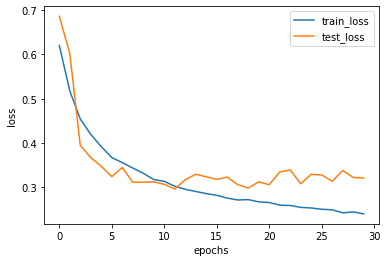

In [17]:
history=model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test_1, y_test))

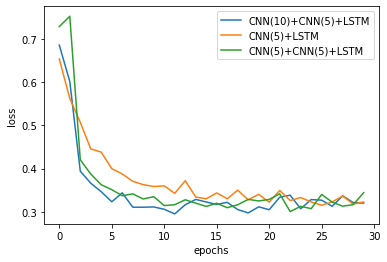

In [23]:
epochs = len(history.history['loss'])
plt.plot(range(0,epochs,1), history.history['val_loss'], label='CNN(10)+CNN(5)+LSTM')
plt.plot(range(0,epochs,1), history1.history['val_loss'], label='CNN(5)+LSTM')
plt.plot(range(0,epochs,1), history2.history['val_loss'], label='CNN(5)+CNN(5)+LSTM')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

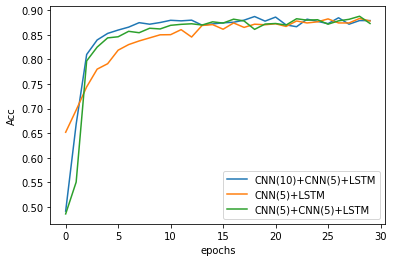

In [24]:
plt.plot(range(0,epochs,1), history.history['val_accuracy'], label='CNN(10)+CNN(5)+LSTM')
plt.plot(range(0,epochs,1), history1.history['val_accuracy'], label='CNN(5)+LSTM')
plt.plot(range(0,epochs,1), history2.history['val_accuracy'], label='CNN(5)+CNN(5)+LSTM')
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

Net_5

只用BN

In [28]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
# model.add(Dropout(0.5))
model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_length))
model.add(BatchNormalization())
model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_length))
model.add(BatchNormalization())
model.add(LSTM(lstm_output_size))
model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = LossHistory()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 745, 64)           256       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 741, 64)           20544     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 370, 64)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 370, 64)          

Epoch 1/30
248/248 [==============================] - 17s 69ms/step - loss: 0.4687 - accuracy: 0.7719 - val_loss: 0.7712 - val_accuracy: 0.4855
Epoch 2/30
248/248 [==============================] - 17s 67ms/step - loss: 0.3314 - accuracy: 0.8654 - val_loss: 0.6170 - val_accuracy: 0.6649
Epoch 3/30
248/248 [==============================] - 16s 66ms/step - loss: 0.2843 - accuracy: 0.8895 - val_loss: 0.3194 - val_accuracy: 0.8721
Epoch 4/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2556 - accuracy: 0.9022 - val_loss: 0.3282 - val_accuracy: 0.8715
Epoch 5/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2393 - accuracy: 0.9095 - val_loss: 0.3346 - val_accuracy: 0.8667
Epoch 6/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2243 - accuracy: 0.9147 - val_loss: 0.3071 - val_accuracy: 0.8795
Epoch 7/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2104 - accuracy: 0.9196 - val_loss: 0.3091 - val_accuracy:

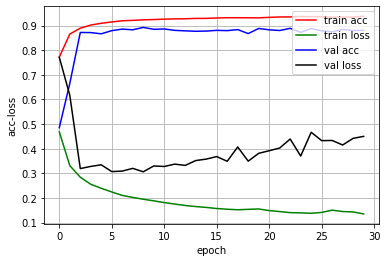

In [29]:
model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])

#模型评估
score = model.evaluate(X_test_1, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#绘制acc-loss曲线
history.loss_plot('epoch')

In [30]:
## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-4).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine_5.csv')

Net_6

In [31]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
# model.add(Dropout(0.2))
model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_length))
model.add(BatchNormalization())
model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_length))
model.add(BatchNormalization())
model.add(LSTM(lstm_output_size))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = LossHistory()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 745, 64)           256       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 741, 64)           20544     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 370, 64)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 370, 64)          

Epoch 1/30
248/248 [==============================] - 17s 68ms/step - loss: 0.4905 - accuracy: 0.7529 - val_loss: 0.8024 - val_accuracy: 0.4855
Epoch 2/30
248/248 [==============================] - 16s 67ms/step - loss: 0.3559 - accuracy: 0.8533 - val_loss: 0.7181 - val_accuracy: 0.5731
Epoch 3/30
248/248 [==============================] - 17s 67ms/step - loss: 0.3045 - accuracy: 0.8807 - val_loss: 0.3273 - val_accuracy: 0.8664
Epoch 4/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2734 - accuracy: 0.8943 - val_loss: 0.3654 - val_accuracy: 0.8457
Epoch 5/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2485 - accuracy: 0.9048 - val_loss: 0.3557 - val_accuracy: 0.8624
Epoch 6/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2333 - accuracy: 0.9089 - val_loss: 0.3364 - val_accuracy: 0.8755
Epoch 7/30
248/248 [==============================] - 16s 67ms/step - loss: 0.2218 - accuracy: 0.9147 - val_loss: 0.3782 - val_accuracy:

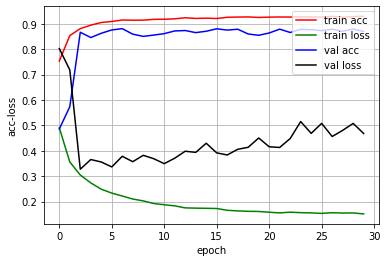

In [32]:
model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])

#模型评估
score = model.evaluate(X_test_1, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#绘制acc-loss曲线
history.loss_plot('epoch')

In [33]:
## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine_6.csv')

Net_7

In [34]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
# model.add(Dropout(0.2))
model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_length))
model.add(BatchNormalization())
model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_length))
model.add(BatchNormalization())
model.add(LSTM(lstm_output_size, dropout=0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = LossHistory()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 745, 64)           256       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 741, 64)           20544     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 370, 64)           0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 370, 64)          

Epoch 1/30
248/248 [==============================] - 17s 69ms/step - loss: 0.5324 - accuracy: 0.7203 - val_loss: 0.6064 - val_accuracy: 0.6200
Epoch 2/30
248/248 [==============================] - 17s 67ms/step - loss: 0.3904 - accuracy: 0.8326 - val_loss: 0.4017 - val_accuracy: 0.8400
Epoch 3/30
248/248 [==============================] - 16s 66ms/step - loss: 0.3446 - accuracy: 0.8617 - val_loss: 0.3372 - val_accuracy: 0.8559
Epoch 4/30
248/248 [==============================] - 17s 67ms/step - loss: 0.3058 - accuracy: 0.8801 - val_loss: 0.3481 - val_accuracy: 0.8579
Epoch 5/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2861 - accuracy: 0.8884 - val_loss: 0.3256 - val_accuracy: 0.8718
Epoch 6/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2676 - accuracy: 0.8984 - val_loss: 0.3109 - val_accuracy: 0.8800
Epoch 7/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2593 - accuracy: 0.9013 - val_loss: 0.3305 - val_accuracy:

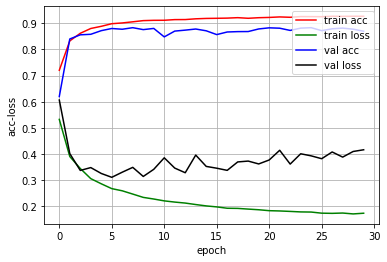

In [35]:
model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])

#模型评估
score = model.evaluate(X_test_1, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#绘制acc-loss曲线
history.loss_plot('epoch')

In [36]:
## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine_7.csv')

Net_8

In [37]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_length))
model.add(BatchNormalization())
model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_length))
model.add(BatchNormalization())
model.add(LSTM(lstm_output_size, dropout=0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = LossHistory()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_10 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 745, 64)           256       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 741, 64)           20544     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 370, 64)         

Epoch 1/30
248/248 [==============================] - 17s 70ms/step - loss: 0.5787 - accuracy: 0.6730 - val_loss: 0.8498 - val_accuracy: 0.4855
Epoch 2/30
248/248 [==============================] - 17s 68ms/step - loss: 0.4475 - accuracy: 0.8002 - val_loss: 0.6749 - val_accuracy: 0.6072
Epoch 3/30
248/248 [==============================] - 17s 68ms/step - loss: 0.3976 - accuracy: 0.8352 - val_loss: 0.3516 - val_accuracy: 0.8542
Epoch 4/30
248/248 [==============================] - 17s 68ms/step - loss: 0.3578 - accuracy: 0.8533 - val_loss: 0.3375 - val_accuracy: 0.8533
Epoch 5/30
248/248 [==============================] - 17s 67ms/step - loss: 0.3263 - accuracy: 0.8715 - val_loss: 0.3882 - val_accuracy: 0.8368
Epoch 6/30
248/248 [==============================] - 17s 68ms/step - loss: 0.3087 - accuracy: 0.8771 - val_loss: 0.3188 - val_accuracy: 0.8701
Epoch 7/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2912 - accuracy: 0.8861 - val_loss: 0.3337 - val_accuracy:

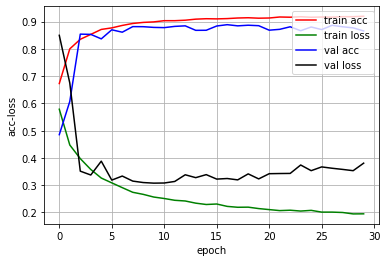

In [38]:
model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])

#模型评估
score = model.evaluate(X_test_1, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#绘制acc-loss曲线
history.loss_plot('epoch')

In [39]:
## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine_8.csv')

Net_9

In [42]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
# model.add(Dropout(0.5))
model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=pool_length))
model.add(Activation(activation='relu'))
model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=pool_length))
model.add(Activation(activation='relu'))
model.add(LSTM(lstm_output_size))
model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = LossHistory()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
batch_normalization_14 (Batc (None, 1491, 64)          256       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
activation_14 (Activation)   (None, 745, 64)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 741, 64)           20544     
_________________________________________________________________
batch_normalization_15 (Batc (None, 741, 64)         

Epoch 1/30
248/248 [==============================] - 17s 68ms/step - loss: 0.4971 - accuracy: 0.7498 - val_loss: 0.6641 - val_accuracy: 0.5296
Epoch 2/30
248/248 [==============================] - 17s 68ms/step - loss: 0.3468 - accuracy: 0.8547 - val_loss: 0.3668 - val_accuracy: 0.8391
Epoch 3/30
248/248 [==============================] - 17s 68ms/step - loss: 0.2932 - accuracy: 0.8865 - val_loss: 0.3187 - val_accuracy: 0.8749
Epoch 4/30
248/248 [==============================] - 17s 68ms/step - loss: 0.2654 - accuracy: 0.8991 - val_loss: 0.3499 - val_accuracy: 0.8638
Epoch 5/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2490 - accuracy: 0.9068 - val_loss: 0.3253 - val_accuracy: 0.8795
Epoch 6/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2357 - accuracy: 0.9115 - val_loss: 0.3704 - val_accuracy: 0.8633
Epoch 7/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2232 - accuracy: 0.9167 - val_loss: 0.3337 - val_accuracy:

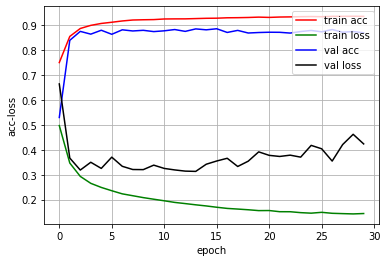

In [43]:
model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])

#模型评估
score = model.evaluate(X_test_1, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#绘制acc-loss曲线
history.loss_plot('epoch')

In [44]:
## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-4).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine_9.csv')

Net_10

In [45]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
# model.add(Dropout(0.5))
model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=pool_length))
model.add(Activation(activation='relu'))
model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=pool_length))
model.add(Activation(activation='relu'))
model.add(LSTM(lstm_output_size))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = LossHistory()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
batch_normalization_16 (Batc (None, 1491, 64)          256       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
activation_17 (Activation)   (None, 745, 64)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 741, 64)           20544     
_________________________________________________________________
batch_normalization_17 (Batc (None, 741, 64)         

Epoch 1/30
248/248 [==============================] - 17s 69ms/step - loss: 0.5081 - accuracy: 0.7409 - val_loss: 0.6783 - val_accuracy: 0.5202
Epoch 2/30
248/248 [==============================] - 17s 68ms/step - loss: 0.3782 - accuracy: 0.8408 - val_loss: 0.3844 - val_accuracy: 0.8380
Epoch 3/30
248/248 [==============================] - 17s 67ms/step - loss: 0.3281 - accuracy: 0.8719 - val_loss: 0.3876 - val_accuracy: 0.8366
Epoch 4/30
248/248 [==============================] - 17s 68ms/step - loss: 0.2967 - accuracy: 0.8849 - val_loss: 0.3668 - val_accuracy: 0.8417
Epoch 5/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2768 - accuracy: 0.8960 - val_loss: 0.3279 - val_accuracy: 0.8664
Epoch 6/30
248/248 [==============================] - 17s 68ms/step - loss: 0.2600 - accuracy: 0.9045 - val_loss: 0.3162 - val_accuracy: 0.8746
Epoch 7/30
248/248 [==============================] - 17s 67ms/step - loss: 0.2442 - accuracy: 0.9076 - val_loss: 0.3648 - val_accuracy:

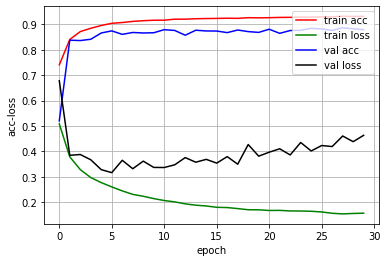

In [46]:
model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])

#模型评估
score = model.evaluate(X_test_1, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#绘制acc-loss曲线
history.loss_plot('epoch')

In [47]:
## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine_10.csv')

Net_11

In [48]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
# model.add(Dropout(0.5))
model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=pool_length))
model.add(Activation(activation='relu'))
model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=pool_length))
model.add(Activation(activation='relu'))
model.add(LSTM(lstm_output_size, dropout=0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = LossHistory()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
batch_normalization_18 (Batc (None, 1491, 64)          256       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
activation_20 (Activation)   (None, 745, 64)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 741, 64)           20544     
_________________________________________________________________
batch_normalization_19 (Batc (None, 741, 64)         

Epoch 1/30
248/248 [==============================] - 17s 70ms/step - loss: 0.5630 - accuracy: 0.6945 - val_loss: 0.6136 - val_accuracy: 0.7172
Epoch 2/30
248/248 [==============================] - 17s 68ms/step - loss: 0.4255 - accuracy: 0.8087 - val_loss: 0.4345 - val_accuracy: 0.7897
Epoch 3/30
248/248 [==============================] - 17s 68ms/step - loss: 0.3734 - accuracy: 0.8462 - val_loss: 0.3501 - val_accuracy: 0.8550
Epoch 4/30
248/248 [==============================] - 17s 68ms/step - loss: 0.3331 - accuracy: 0.8670 - val_loss: 0.3483 - val_accuracy: 0.8539
Epoch 5/30
248/248 [==============================] - 17s 68ms/step - loss: 0.3116 - accuracy: 0.8761 - val_loss: 0.3197 - val_accuracy: 0.8709
Epoch 6/30
248/248 [==============================] - 17s 68ms/step - loss: 0.2970 - accuracy: 0.8853 - val_loss: 0.3053 - val_accuracy: 0.8758
Epoch 7/30
248/248 [==============================] - 17s 68ms/step - loss: 0.2773 - accuracy: 0.8945 - val_loss: 0.3068 - val_accuracy:

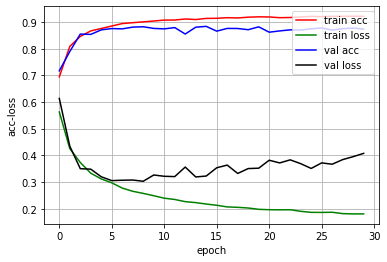

In [49]:
model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])

#模型评估
score = model.evaluate(X_test_1, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#绘制acc-loss曲线
history.loss_plot('epoch')

In [50]:
## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine_11.csv')

Net_12

In [51]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.5))
model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=pool_length))
model.add(Activation(activation='relu'))
model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=pool_length))
model.add(Activation(activation='relu'))
model.add(LSTM(lstm_output_size, dropout=0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = LossHistory()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_14 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
batch_normalization_20 (Batc (None, 1491, 64)          256       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
activation_23 (Activation)   (None, 745, 64)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 741, 64)         

Epoch 1/30
248/248 [==============================] - 18s 71ms/step - loss: 0.6398 - accuracy: 0.6156 - val_loss: 0.6019 - val_accuracy: 0.7203
Epoch 2/30
248/248 [==============================] - 17s 69ms/step - loss: 0.5071 - accuracy: 0.7497 - val_loss: 0.4553 - val_accuracy: 0.7834
Epoch 3/30
248/248 [==============================] - 17s 70ms/step - loss: 0.4517 - accuracy: 0.7874 - val_loss: 0.3950 - val_accuracy: 0.8178
Epoch 4/30
248/248 [==============================] - 17s 70ms/step - loss: 0.4092 - accuracy: 0.8173 - val_loss: 0.3683 - val_accuracy: 0.8388
Epoch 5/30
248/248 [==============================] - 17s 69ms/step - loss: 0.3920 - accuracy: 0.8297 - val_loss: 0.3424 - val_accuracy: 0.8508
Epoch 6/30
248/248 [==============================] - 17s 70ms/step - loss: 0.3691 - accuracy: 0.8417 - val_loss: 0.3588 - val_accuracy: 0.8567
Epoch 7/30
248/248 [==============================] - 17s 69ms/step - loss: 0.3549 - accuracy: 0.8508 - val_loss: 0.3338 - val_accuracy:

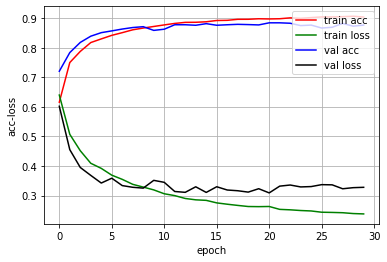

In [52]:
model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])

#模型评估
score = model.evaluate(X_test_1, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#绘制acc-loss曲线
history.loss_plot('epoch')

In [53]:
## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine_12.csv')

论文里示例

In [16]:
model = Sequential()
model.add(Embedding(21, 4, input_length=8))
# model.add(Dropout(0.5))
# model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
# model.add(MaxPooling1D(pool_size=pool_length))
# model.add(BatchNormalization())
# model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
# model.add(MaxPooling1D(pool_size=pool_length))
# model.add(BatchNormalization())
# model.add(LSTM(lstm_output_size, dropout=0.2))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

model.save('model.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 4)              84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


In [17]:
S1 = np.array([11, 16, 5, 11, 18, 13, 17, 0])
output_array = model.predict(S1)
# assert output_array.shape == (10, 4, 8)
output_array

array([[[-0.02803973,  0.0130627 , -0.01508399, -0.0315336 ]],

       [[-0.01654423, -0.00522466,  0.02253783,  0.0015481 ]],

       [[-0.04344388, -0.04923941,  0.03383968, -0.00470303]],

       [[-0.02803973,  0.0130627 , -0.01508399, -0.0315336 ]],

       [[ 0.00301045, -0.04346204,  0.04243422, -0.0247539 ]],

       [[ 0.02257952,  0.01473874,  0.01691712, -0.01485534]],

       [[-0.01535804,  0.04933903,  0.02822008, -0.03260247]],

       [[ 0.00896614, -0.00744981,  0.02514133,  0.01793215]]],
      dtype=float32)

In [15]:
S1 = np.array([11, 16, 5, 11, 18, 13, 17, 0])
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=0).output)
intermediate_layer_model.predict(S1)

array([[[-0.02425779,  0.02444167,  0.01988081,  0.00470313,
          0.04187587,  0.00148051,  0.04312034, -0.04351442]],

       [[-0.0326717 , -0.04970299,  0.04091516, -0.04640843,
          0.0363796 , -0.00433572, -0.00041175,  0.0190792 ]],

       [[-0.04468783,  0.02295846, -0.03964062,  0.02617342,
         -0.04292312, -0.04646894,  0.04180429,  0.03202236]],

       [[-0.02425779,  0.02444167,  0.01988081,  0.00470313,
          0.04187587,  0.00148051,  0.04312034, -0.04351442]],

       [[ 0.02451978,  0.00865405, -0.04084021, -0.04946766,
         -0.04489345,  0.02262355, -0.0101525 ,  0.01748626]],

       [[ 0.0206368 ,  0.03929349,  0.03689499, -0.00327558,
          0.03609506,  0.0347006 ,  0.03607862, -0.03645339]],

       [[ 0.04913468, -0.04002754,  0.03060282, -0.0165536 ,
         -0.01510757, -0.00459641, -0.00606193, -0.03641856]],

       [[-0.01516432,  0.04572609, -0.02686179, -0.02267398,
         -0.02625463, -0.02077403, -0.02707119, -0.00215975]]],


In [66]:
S1 = np.array([11, 16, 5, 11, 18, 13, 17, 0])
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=0).output)
intermediate_layer_model.predict(S1)

array([[[-0.0348847 , -0.03498   , -0.01670543, -0.03891342,
         -0.04735307,  0.02325132,  0.01453454,  0.0449344 ]],

       [[-0.00263296, -0.04919956, -0.00999031,  0.01350976,
         -0.02757715,  0.0350836 ,  0.02265186,  0.04533308]],

       [[ 0.03413272, -0.02514048, -0.02183275,  0.03815273,
         -0.01343901, -0.03111864, -0.02323846,  0.00077508]],

       [[-0.0348847 , -0.03498   , -0.01670543, -0.03891342,
         -0.04735307,  0.02325132,  0.01453454,  0.0449344 ]],

       [[-0.02259727,  0.01519295,  0.04167901,  0.02265045,
         -0.01723391, -0.04187206,  0.04621328,  0.0284979 ]],

       [[-0.01460146, -0.01477756,  0.03462143,  0.01839515,
          0.00208818, -0.03640056, -0.02216767, -0.01817857]],

       [[ 0.04292739,  0.03269759,  0.03620802, -0.00636169,
         -0.01493566,  0.04763475, -0.04836885,  0.01799593]],

       [[-0.00537934,  0.04896431, -0.01576782, -0.04522796,
          0.01194081,  0.01414121,  0.00818812,  0.0136845 ]]],


In [22]:
n1 = np.array([[[-0.0348847 , -0.03498   , -0.01670543, -0.03891342,
         -0.04735307,  0.02325132,  0.01453454,  0.0449344 ]],

       [[-0.00263296, -0.04919956, -0.00999031,  0.01350976,
         -0.02757715,  0.0350836 ,  0.02265186,  0.04533308]],

       [[ 0.03413272, -0.02514048, -0.02183275,  0.03815273,
         -0.01343901, -0.03111864, -0.02323846,  0.00077508]],

       [[-0.0348847 , -0.03498   , -0.01670543, -0.03891342,
         -0.04735307,  0.02325132,  0.01453454,  0.0449344 ]],

       [[-0.02259727,  0.01519295,  0.04167901,  0.02265045,
         -0.01723391, -0.04187206,  0.04621328,  0.0284979 ]],

       [[-0.01460146, -0.01477756,  0.03462143,  0.01839515,
          0.00208818, -0.03640056, -0.02216767, -0.01817857]],

       [[ 0.04292739,  0.03269759,  0.03620802, -0.00636169,
         -0.01493566,  0.04763475, -0.04836885,  0.01799593]],

       [[-0.00537934,  0.04896431, -0.01576782, -0.04522796,
          0.01194081,  0.01414121,  0.00818812,  0.0136845 ]]])

n2 = np.array([[0.1 , 0.2   , 0.3, -0.5,
         0.1,  0.3,  -0.1,  0.2 ],

       [0.2, -0.1, 0.2,  -0.7,
         0.1,  -0.3 ,  -0.2,  0.4]])
print(n1.shape)
print(n2.shape)
np.convolve(n1,n2, 'valid')


(8, 1, 8)
(2, 1, 8)


ValueError: object too deep for desired array

In [25]:
np.convolve([[1,2,3],[1,2,3]],[0,1,0.5], 'valid')

ValueError: object too deep for desired array

In [26]:
n1 = np.array([[-0.0348847 , -0.03498   , -0.01670543, -0.03891342,
         -0.04735307,  0.02325132,  0.01453454,  0.0449344 ],

       [-0.00263296, -0.04919956, -0.00999031,  0.01350976,
         -0.02757715,  0.0350836 ,  0.02265186,  0.04533308],

       [ 0.03413272, -0.02514048, -0.02183275,  0.03815273,
         -0.01343901, -0.03111864, -0.02323846,  0.00077508],

       [-0.0348847 , -0.03498   , -0.01670543, -0.03891342,
         -0.04735307,  0.02325132,  0.01453454,  0.0449344 ],

       [-0.02259727,  0.01519295,  0.04167901,  0.02265045,
         -0.01723391, -0.04187206,  0.04621328,  0.0284979 ],

       [-0.01460146, -0.01477756,  0.03462143,  0.01839515,
          0.00208818, -0.03640056, -0.02216767, -0.01817857],

       [ 0.04292739,  0.03269759,  0.03620802, -0.00636169,
         -0.01493566,  0.04763475, -0.04836885,  0.01799593],

       [-0.00537934,  0.04896431, -0.01576782, -0.04522796,
          0.01194081,  0.01414121,  0.00818812,  0.0136845 ]])

n2 = np.array([[0.1 , 0.2   , 0.3, -0.5,
         0.1,  0.3,  -0.1,  0.2 ],

       [0.2, -0.1, 0.2,  -0.7,
         0.1,  -0.3 ,  -0.2,  0.4]])
print(n1.shape)
print(n2.shape)
np.convolve(n1,n2, 'valid')

(8, 8)
(2, 8)


ValueError: object too deep for desired array

In [33]:
for i in range(8):
    sum = np.convolve(n1[i],n2[0], 'valid')+np.convolve(n1[i],n2[1], 'valid')
    print(sum)

[0.06516361]
[0.08238153]
[0.03412849]
[0.06516361]
[-0.0006708]
[-0.02902501]
[0.05697688]
[-0.02929669]


In [26]:
#第一次好的结果

model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch,
          validation_data=(X_test_1, y_test))

Epoch 1/30
185/185 [==============================] - 293s 2s/step - loss: 0.6845 - accuracy: 0.5410 - val_loss: 0.6686 - val_accuracy: 0.5753
Epoch 2/30
185/185 [==============================] - 285s 2s/step - loss: 0.6375 - accuracy: 0.6037 - val_loss: 0.6204 - val_accuracy: 0.6206
Epoch 3/30
185/185 [==============================] - 283s 2s/step - loss: 0.5847 - accuracy: 0.6710 - val_loss: 0.5329 - val_accuracy: 0.7139
Epoch 4/30
185/185 [==============================] - 285s 2s/step - loss: 0.5112 - accuracy: 0.7286 - val_loss: 0.4620 - val_accuracy: 0.7673
Epoch 5/30
185/185 [==============================] - 281s 2s/step - loss: 0.4906 - accuracy: 0.7530 - val_loss: 0.4345 - val_accuracy: 0.7920
Epoch 6/30
185/185 [==============================] - 287s 2s/step - loss: 0.4380 - accuracy: 0.7903 - val_loss: 0.4090 - val_accuracy: 0.8132
Epoch 7/30
185/185 [==============================] - 285s 2s/step - loss: 0.4045 - accuracy: 0.8204 - val_loss: 0.3971 - val_accuracy: 0.8276

In [29]:
score, acc = model.evaluate(X_test_1, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)
test_predictions = model.predict_classes(X_test_1,batch_size=128,verbose=0)
#np.savetxt("acc.txt",result_1,fmt="%.8e")
#test_predictions = model.predict(X_test.astype(float))[:]

#accuracy = sum(test_predictions == y_test) / float(len(y_test))
#print (accuracy)
#print("Accuracy: {:.4f}".format(accuracy))

#acc = model.score(X_test, y_test)
#print (acc)
#print("Accuracy: {:.4f}".format(acc))

mcc = matthews_corrcoef(y_test, test_predictions)
print (mcc)
#print("MCC: {:.4f}".format(mcc))

f1 = f1_score(y_test, test_predictions)
print (f1)
#print("F1: {:.4f}".format(f1))

sn = recall_score(y_test, test_predictions)
print (sn)
#print("SN: {:.4f}".format(sn))

ppv = precision_score(y_test, test_predictions)
print (ppv)
#print("PPV: {:.4f}".format(ppv))
print('***********************************************************************')

62/62 [==============================] - 17s 272ms/step - loss: 0.3359 - accuracy: 0.8779
Test score: 0.3358834385871887
Test accuracy: 0.8778538703918457


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.7550995262332199
0.8839059674502712
0.8887272727272727
0.879136690647482
***********************************************************************


In [38]:
X_train_2.reset_index(drop=True)

,mut_residue,ANDN920101,ARGP820101,ARGP820102,ARGP820103,BEGF750101,BEGF750102,BEGF750103,BHAR880101,BIGC670101,...,PolarAA,ChargedAA,PosAA,NegAA,hits,score,pos_1,len,LR,PA
0,575,0.25,0.01,-0.74,-0.54,0.00,0.00,0.13,-0.044,20.8,...,7,8,2,6,3,0.00,0,1419,51.071307,-0.195219
1,99,-0.03,-0.55,0.64,0.46,-0.08,0.11,-0.09,-0.085,-37.9,...,11,0,0,0,27,0.09,0,435,4.440124,0.913916
2,158,-0.15,-1.02,-0.92,-0.42,0.29,-0.10,0.00,0.161,-13.4,...,9,4,3,1,24,0.01,0,428,51.808987,2.724309
3,386,0.40,-0.71,0.10,0.42,0.18,-0.21,0.00,-0.029,-32.5,...,4,9,4,5,19,0.88,0,571,6.124615,0.470921
4,58,0.33,-1.48,-2.26,-2.12,-0.65,-0.28,0.31,0.142,-47.1,...,6,7,2,5,29,0.00,0,376,223.074739,3.780122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23646,146,0.00,-0.90,-0.37,-0.53,0.09,0.00,0.00,-0.076,-16.9,...,5,7,2,5,31,0.24,0,1218,366.442168,3.237182
23647,5,-0.06,1.90,-0.21,-0.05,-0.29,0.00,0.13,0.002,18.7,...,4,3,2,1,3,0.00,0,199,0.299554,-0.422748
23648,135,0.15,0.00,0.13,-0.10,-0.09,-0.28,0.09,0.063,-16.3,...,8,4,1,3,46,0.00,0,466,281.114022,5.079405
23649,339,-0.25,-0.01,-0.11,0.16,-0.08,-0.11,0.09,0.206,17.2,...,5,6,0,6,2,0.00,0,495,36.740983,1.377788


In [37]:
pd.DataFrame(train_output)

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.025917,-0.108404,-0.030535,-0.211958,-0.043845,0.076047,-0.358380,0.057446,0.099429,-0.017191,...,0.215157,-0.000373,-0.621811,0.199273,-0.134140,0.270002,0.571602,0.008976,-0.011990,0.017532
1,0.123554,-0.172977,-0.155697,-0.361417,-0.008764,0.076665,-0.344471,0.107096,0.222284,-0.122216,...,0.276203,0.000634,-0.476117,0.071939,-0.181149,0.375069,0.481482,0.059007,-0.096336,0.021246
2,0.128534,-0.240598,-0.163213,-0.482442,-0.081852,0.032197,-0.451254,0.127328,0.280923,-0.108289,...,0.276503,-0.000303,-0.584561,-0.122291,-0.216428,0.469315,0.539504,0.064589,-0.140597,0.063438
3,0.111513,-0.115660,-0.155551,-0.083087,-0.007559,-0.001044,-0.372976,0.039666,0.112789,-0.098606,...,0.211610,0.000899,0.491671,0.264460,-0.037088,0.086977,0.370583,0.119008,-0.028830,0.013154
4,0.545226,-0.181927,-0.703426,-0.034694,0.390869,-0.023213,-0.603347,-0.017759,0.157932,-0.632879,...,0.487317,0.005750,0.719887,0.343264,-0.095394,0.036234,0.009457,0.497541,-0.129116,-0.473722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23646,0.597368,-0.094390,-0.783518,-0.050673,0.283267,-0.038598,-0.689017,-0.063730,0.182385,-0.720513,...,0.288314,0.001518,0.697239,-0.051855,-0.112354,0.057970,0.259366,0.324366,-0.349146,-0.470314
23647,0.177435,-0.258191,-0.310595,-0.402232,0.065221,-0.024456,-0.447954,-0.012991,0.295819,-0.181253,...,0.255922,-0.001728,-0.145999,-0.354496,-0.437386,0.485127,0.496595,0.079596,-0.177030,-0.113830
23648,0.799518,-0.051633,-0.834997,-0.084859,0.437573,-0.403813,-0.163945,-0.716649,0.162271,-0.746849,...,0.066710,0.006592,0.707475,-0.105464,-0.018022,0.155646,0.026298,0.466596,-0.725736,-0.624131
23649,0.616725,-0.081730,-0.555613,-0.034757,0.087678,-0.030414,-0.688238,0.017986,0.171439,-0.543848,...,0.205693,0.001794,0.730930,0.402585,-0.017688,0.067528,0.043731,0.379973,-0.185484,-0.397965


In [39]:
## lstm层输出的70个
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
train_output = intermediate_layer_model.predict(X_train_1)

## 共70+1085个

X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
X_train_3

## lstm层输出的70个
test_output = intermediate_layer_model.predict(X_test_1)

## 共70+1085个

X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
X_test_3

,0,1,2,3,4,5,6,7,8,9,...,PolarAA,ChargedAA,PosAA,NegAA,hits,score,pos_1,len,LR,PA
0,0.286361,-0.189747,-0.407407,-0.418567,-0.007374,-0.032449,-0.425573,0.086837,0.289887,-0.236403,...,7,2,1,1,18,0.26,0,649,15.033051,3.000642
1,0.090595,-0.262631,-0.068800,-0.411746,-0.041555,0.037499,-0.239783,0.050192,0.276874,-0.079222,...,6,6,2,4,87,0.00,0,312,-7.496016,0.414242
2,0.365438,-0.154988,-0.323004,-0.133501,0.051917,-0.008724,-0.449745,0.065476,0.236040,-0.257321,...,8,2,1,1,22,0.06,0,243,28.253320,3.773510
3,0.079933,-0.258093,-0.052949,-0.328820,-0.025348,0.013637,-0.357182,0.059966,0.136545,-0.032891,...,1,9,7,2,399,0.01,0,376,38.093033,1.104595
4,0.692303,-0.058426,-0.679352,-0.030775,0.083420,-0.044940,-0.525375,-0.081199,0.233876,-0.687099,...,7,3,1,2,93,0.33,0,680,12.125239,0.849024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7879,0.787718,-0.080408,-0.927448,-0.007852,0.598288,-0.010043,-0.803579,-0.014766,0.179769,-0.928050,...,1,8,5,3,47,0.00,0,821,805.127885,2.114002
7880,0.472936,-0.285612,-0.423943,-0.386963,-0.011361,-0.176949,-0.467517,-0.010594,0.269296,-0.278480,...,8,4,4,0,6,0.02,0,631,175.190120,2.775601
7881,0.531645,-0.100028,-0.691113,-0.017998,0.429909,-0.018697,-0.665728,-0.000444,0.196426,-0.663491,...,9,4,2,2,8,0.00,0,195,451.215032,1.104595
7882,0.410335,-0.064452,-0.231773,-0.022524,0.241969,-0.028715,-0.590268,0.009053,0.087833,-0.209575,...,9,4,2,2,3,0.00,0,570,300.819355,1.104595


In [40]:
no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'LGBM_all_try_combine.csv')

In [13]:
model_1 = Sequential()
model_1.add(Embedding(max_features, embedding_size, input_length=maxlen))
model_1.add(Dropout(0.5))
model_1.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
model_1.add(MaxPooling1D(pool_size=pool_length))
# model_1.add(BatchNormalization())
model_1.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
model_1.add(MaxPooling1D(pool_size=pool_length))
# model_1.add(BatchNormalization())
model_1.add(LSTM(lstm_output_size))
input_left = model_1.input
output_left = model_1.output


model_2 = Sequential()
model_2.add(Embedding(max_features, embedding_size, input_length=maxlen))
model_2.add(Dropout(0.5))
model_2.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
model_2.add(MaxPooling1D(pool_size=pool_length))
# model_2.add(BatchNormalization())
model_2.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
model_2.add(MaxPooling1D(pool_size=pool_length))
# model_2.add(BatchNormalization())
model_2.add(LSTM(lstm_output_size))
input_right = model_2.input
output_right = model_2.output


print(model_1.output)
print(K.int_shape(model_1.output))
print(model_2.output)
print(K.int_shape(model_2.output))
print(tf.convert_to_tensor(X_train_3))
print(K.int_shape(tf.convert_to_tensor(X_train_3)))
# model concat
#归一化
concatenated = concatenate([output_left, output_right, tf.convert_to_tensor(X_train_3)], axis = -1)
print(concatenated.shape)

final_output = Dense(1, activation='sigmoid')(concatenated)

model = Model(inputs=[input_left, input_right],outputs=final_output)
# , tf.convert_to_tensor(X_train_3)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Tensor("lstm/PartitionedCall:0", shape=(None, 20), dtype=float64)
(None, 20)
Tensor("lstm_1/PartitionedCall:0", shape=(None, 20), dtype=float64)
(None, 20)
tf.Tensor(
[[0.49094411 0.4871048  0.48710898 ... 0.49142192 0.49022781 0.48713297]
 [0.4913174  0.48711167 0.48708465 ... 0.49493079 0.48733456 0.48710552]
 [0.5073985  0.48710674 0.48709331 ... 0.53464829 0.48722481 0.48710676]
 ...
 [0.49370642 0.48710674 0.48709331 ... 0.49654338 0.48734158 0.48710552]
 [0.48779359 0.48710779 0.48713586 ... 0.49237753 0.48809805 0.48710805]
 [0.49075    0.48710689 0.4871157  ... 0.49184    0.48872869 0.48713335]], shape=(35756, 1085), dtype=float64)
(35756, 1085)
(35756, 1125)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 2000)]       0                                            
_____

In [33]:
x = Input(shape=(32,))
x

<tf.Tensor 'input_2:0' shape=(None, 32) dtype=float32>

In [15]:
print('Train...')
# model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,
#           validation_data=(X_test, y_test))
# model.fit(X_train_1, X_train_2, X_train_3, y_train, epochs=nb_epoch,
#           validation_data=(X_test_1, X_test_2, X_test_3, y_test))
model.fit([X_train_1, X_train_2], y_train, epochs=nb_epoch, validation_data=([X_test_1, X_test_2], y_test))
# model.fit([X_train_1, X_train_2], y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=([X_test_1, X_test_2], y_test))
json_string = model.to_json()
open('my_model_ponall.json', 'w').write(json_string)
model.save_weights('my_model_ponall_weights.h5')

Train...
Epoch 1/30


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Incompatible shapes: [32,1] vs. [35756,1]
	 [[node gradient_tape/binary_crossentropy/logistic_loss/mul/Mul (defined at <ipython-input-14-84f207326215>:6) ]]
  (1) Invalid argument:  Incompatible shapes: [32,1] vs. [35756,1]
	 [[node gradient_tape/binary_crossentropy/logistic_loss/mul/Mul (defined at <ipython-input-14-84f207326215>:6) ]]
	 [[gradient_tape/functional_1/embedding/embedding_lookup/Reshape/_40]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_6541]

Function call stack:
train_function -> train_function


In [11]:
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)
test_predictions = model.predict_classes(X_test,batch_size=128,verbose=0)
#np.savetxt("acc.txt",result_1,fmt="%.8e")
#test_predictions = model.predict(X_test.astype(float))[:]

#accuracy = sum(test_predictions == y_test) / float(len(y_test))
#print (accuracy)
#print("Accuracy: {:.4f}".format(accuracy))

#acc = model.score(X_test, y_test)
#print (acc)
#print("Accuracy: {:.4f}".format(acc))

mcc = matthews_corrcoef(y_test, test_predictions)
print (mcc)
#print("MCC: {:.4f}".format(mcc))

f1 = f1_score(y_test, test_predictions)
print (f1)
#print("F1: {:.4f}".format(f1))

sn = recall_score(y_test, test_predictions)
print (sn)
#print("SN: {:.4f}".format(sn))

ppv = precision_score(y_test, test_predictions)
print (ppv)
#print("PPV: {:.4f}".format(ppv))
print('***********************************************************************')